# Shapley for data valuation

This notebook introduces Shapley methods for the computation of data value using pyDVL.

In order to illustrate the practical advantages, we will predict the popularity of songs in the dataset [Top Hits Spotify from 2000-2019](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019), and highlight how data valuation can help investigate and boost the performance of the models. In doing so, we will describe the basic usage patterns of pyDVL.

Recall that data value is a function of three things:

1. The dataset.
2. The model.
3. The performance metric or scoring function.

Below we will describe how to instantiate each one of these objects and how to use them for data valuation. Please also see the [documentation on data valuation](../30-data-valuation.rst).

## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate has been omitted for convenience.

</div>

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import os
import random

import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)

random_state = 24

is_CI = os.environ.get("CI")
enable_cache = not is_CI
random.seed(random_state)

We will be using the following functions from pyDVL. The main entry point is the function [compute_shapley_values()](../pydvl/value/shapley/common.rst#pydvl.value.shapley.common.compute_shapley_values), which provides a facade to all Shapley methods. In order to use it we need the classes [Dataset](../pydvl/utils/dataset.rst#pydvl.utils.dataset.Dataset), [Utility](../pydvl/utils/utility.rst#pydvl.utils.utility.Utility) and [Scorer](../pydvl/utils/score.rst#pydvl.utils.score.Scorer).

In [3]:
from pydvl.reporting.plots import plot_shapley
from pydvl.utils.dataset import GroupedDataset, load_spotify_dataset
from pydvl.value import *

## Loading and grouping the dataset

pyDVL provides a convenience function [load_spotify_dataset()](../pydvl/utils/dataset.rst#pydvl.utils.dataset.load_spotify_dataset) which downloads data on songs published after 2014, and splits 30% of data for testing, and 30% of the remaining data for validation. The return value is a triple of training, validation and test data as lists of the form `[X_input, Y_label]`.

In [4]:
training_data, val_data, test_data = load_spotify_dataset(
    val_size=0.3, test_size=0.3, target_column="popularity", random_state=random_state
)

In [5]:
# In CI we only use a subset of the training set
if is_CI:
    training_data[0] = training_data[0].iloc[:5]
    training_data[1] = training_data[1].iloc[:5]

In [6]:
training_data[0].head()

,artist,song,duration_ms,explicit,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
1561,Fetty Wap,679 (feat. Remy Boyz),196693,True,2015,0.618,0.717,7,-5.738,1,0.3180,0.00256,0.000000,0.6250,0.603,190.050,8
1410,Meghan Trainor,All About That Bass,187920,True,2015,0.807,0.887,9,-3.726,1,0.0503,0.05730,0.000003,0.1240,0.961,134.052,14
1772,Katy Perry,Chained To The Rhythm,237733,False,2017,0.562,0.800,0,-5.404,1,0.1120,0.08140,0.000000,0.1990,0.471,95.029,14
1670,Sigala,Sweet Lovin' - Radio Edit,202149,False,2015,0.683,0.910,10,-1.231,1,0.0515,0.05530,0.000005,0.3360,0.674,124.977,15
1780,Liam Payne,Strip That Down,204502,False,2017,0.869,0.485,6,-5.595,1,0.0545,0.24600,0.000000,0.0765,0.527,106.028,14


The dataset has many high-level features, some quite intuitive ('duration_ms' or 'tempo'), while others are a bit more cryptic ('valence'?). For information on each feature, please consult [the dataset's website](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019).

In our analysis, we will use all the columns, except for 'artist' and 'song', to predict the 'popularity' of each song. We will nonetheless keep the information on song and artist in a separate object for future reference.

In [7]:
song_name = training_data[0]["song"]
artist = training_data[0]["artist"]
training_data[0] = training_data[0].drop(["song", "artist"], axis=1)
test_data[0] = test_data[0].drop(["song", "artist"], axis=1)
val_data[0] = val_data[0].drop(["song", "artist"], axis=1)

Input and label data are then used to instantiate a [Dataset](../pydvl/utils/dataset.rst#pydvl.utils.dataset.Dataset) object:

In [8]:
dataset = Dataset(*training_data, *val_data)

The calculation of exact Shapley values is computationally very expensive (exponentially so!) because it requires training the model on every possible subset of the training set. For this reason, PyDVL implements techniques to speed up the calculation, such as [Monte Carlo approximations](../pydvl/value/shapley/montecarlo.rst), [surrogate models](../pydvl/utils/utility.rst#pydvl.utils.utility.DataUtilityLearning) or [caching](../pydvl/utils/caching.rst) of intermediate results and grouping of data to calculate group Shapley values instead of single data points.

In our case, we will group songs by artist and calculate the Shapley value for the artists. Given the [pandas Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) for 'artist', to group the dataset by it, one does the following:

In [9]:
grouped_dataset = GroupedDataset.from_dataset(dataset=dataset, data_groups=artist)

## Creating the utility and computing values

Now we can calculate the contribution of each group to the model performance.

As a model, we use scikit-learn's [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html), but pyDVL can work with any model from sklearn, xgboost or lightgbm. More precisely, any model that implements the protocol [pydvl.utils.types.SupervisedModel](../pydvl/utils/types.rst#pydvl.utils.types.SupervisedModel), which is just the standard sklearn interface of `fit()`,`predict()` and `score()` can be used to construct the utility.

The third and final component is the scoring function. It can be anything like accuracy or $R^2$, and is set with a string from the [standard sklearn scoring methods](https://scikit-learn.org/stable/modules/model_evaluation.html). Please refer to that documentation on information on how to define your own scoring function.

We group dataset, model and scoring function into an instance of [Utility](../pydvl/utils/utility.rst#pydvl.utils.utility.Utility).

In [10]:
utility = Utility(
    model=GradientBoostingRegressor(n_estimators=3),
    data=grouped_dataset,
    scorer=Scorer("neg_mean_absolute_error", default=0.0),
    enable_cache=enable_cache,
)
values = compute_shapley_values(
    utility,
    mode=ShapleyMode.TruncatedMontecarlo,
    done=RelativeStandardError(threshold=0.3, fraction=0.9) | MaxUpdates(200),
    n_jobs=-1,
    worker_update_period=0.5,
    coordinator_update_period=1,
)
values.sort(key="value")
df = values.to_dataframe(column="data_value", use_names=True)

The function [compute_shapley_values()](../pydvl/value/shapley/common.rst#pydvl.value.shapley.common.compute_shapley_values) serves as a common access point to all Shapley methods. For several of them, we choose a `StoppingCriterion` with the argument `done=`. In this case we choose to stop when the ratio of standard error to value is below 0.3 for at least 90% of the training points, or if the number of updates of any index exceeds 200. The `mode` argument specifies the Shapley method to use. In this case, we use the [Truncated Monte Carlo approximation](../pydvl/value/shapley/truncated.rst#pydvl.value.shapley.truncated.truncated_montecarlo_shapley), which is the fastest of the Monte Carlo methods.

Let's take a look at the returned dataframe:

In [11]:
df.head()

,data_value,data_value_stderr
5 Seconds of Summer,-1.583986,0.175742
Little Mix,-1.378706,0.064739
CNCO,-1.371991,0.098652
Astrid S,-1.323620,0.131028
AlunaGeorge,-1.309662,0.086501


The first thing to notice is that we sorted the results in ascending order of Shapley value. The index holds the labels for each data group: in this case, artist names. The column `data_value` is just that: the Shapley Data value, and `data_value_stderr` is its estimated standard error because we are using a Monte Carlo approximation.

Let us plot the results. In the next cell we will take the 30 artists with the lowest score and plot their values with (approximate) error bars. Keep in mind that Monte Carlo Shapley is typically very noisy, so it may take several steps to arrive at a clean estimate.

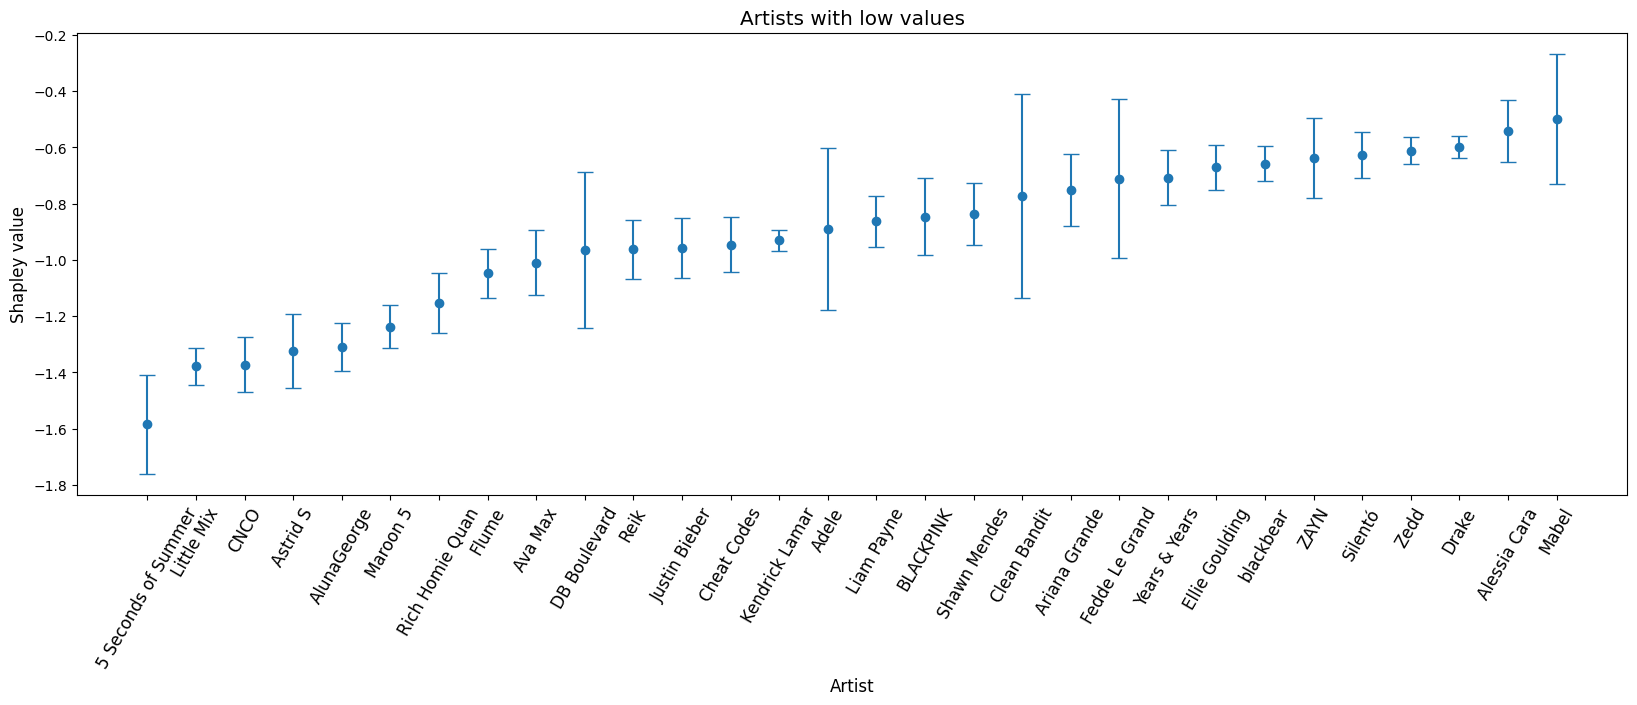

In [12]:
low_dvl = df.iloc[:30]
fig, ax = plt.subplots()
plot_shapley(
    low_dvl,
    ax=ax,
    title="Artists with low values",
    xlabel="Artist",
    ylabel="Shapley value",
)
plt.show()

We can immediately see that many artists (groups of samples) have very low, even negative value, which means that they tend to decrease the total score of the model when present in the training set! What happens if we remove them?

In the next cell we create a new training set excluding the artists with the lowest scores:

In [13]:
low_dvl_artists = df.iloc[:30].index.to_list()
artist_filter = ~artist.isin(low_dvl_artists)
X_train_good_dvl = training_data[0][artist_filter]
y_train_good_dvl = training_data[1][artist_filter]

Now we will use this "cleaned" dataset to retrain the same model and compare its mean absolute error to the one trained on the full dataset. Notice that the score now is calculated using the test set, while in the calculation of the Shapley values we were using the validation set.

In [14]:
model_good_data = GradientBoostingRegressor(n_estimators=3).fit(
    X_train_good_dvl, y_train_good_dvl
)
error_good_data = mean_absolute_error(
    model_good_data.predict(test_data[0]), test_data[1]
)

model_all_data = GradientBoostingRegressor(n_estimators=3).fit(
    training_data[0], training_data[1]
)
error_all_data = mean_absolute_error(model_all_data.predict(test_data[0]), test_data[1])

print(f"Improvement: {100*(error_all_data - error_good_data)/error_all_data:02f}%")

Improvement: 14.601513%


The score has improved by almost 15%! This is quite an important result, as it shows a consistent process to improve the performance of a model by excluding data points from its training set.

<div class="alert alert-warning">

One must however proceed with caution instead of simply throwing away data. For one, `mean_absolute_error` is an estimate of generalization error on unseen data, so the improvement we see on the test set might not be as large upon deployment. It would be advisable to cross-validate this whole process to obtain more conservative estimates. It is also advisable to manually inspect the artists with low value and to try to understand the reason why the model behaves like it does. Finally, remember that **the value depends on the model chosen**! Artists that are detrimental to the Gradient Boosting Regressor might be informative for a different model (although it is likely that the worst ones share some characteristic making them "bad" for other regressors).

</div>

## Evaluation on anomalous data

One interesting test is to corrupt some data and to monitor how their value changes. To do this, we will take one of the artists with the highest value and set the popularity of all their songs to 0.

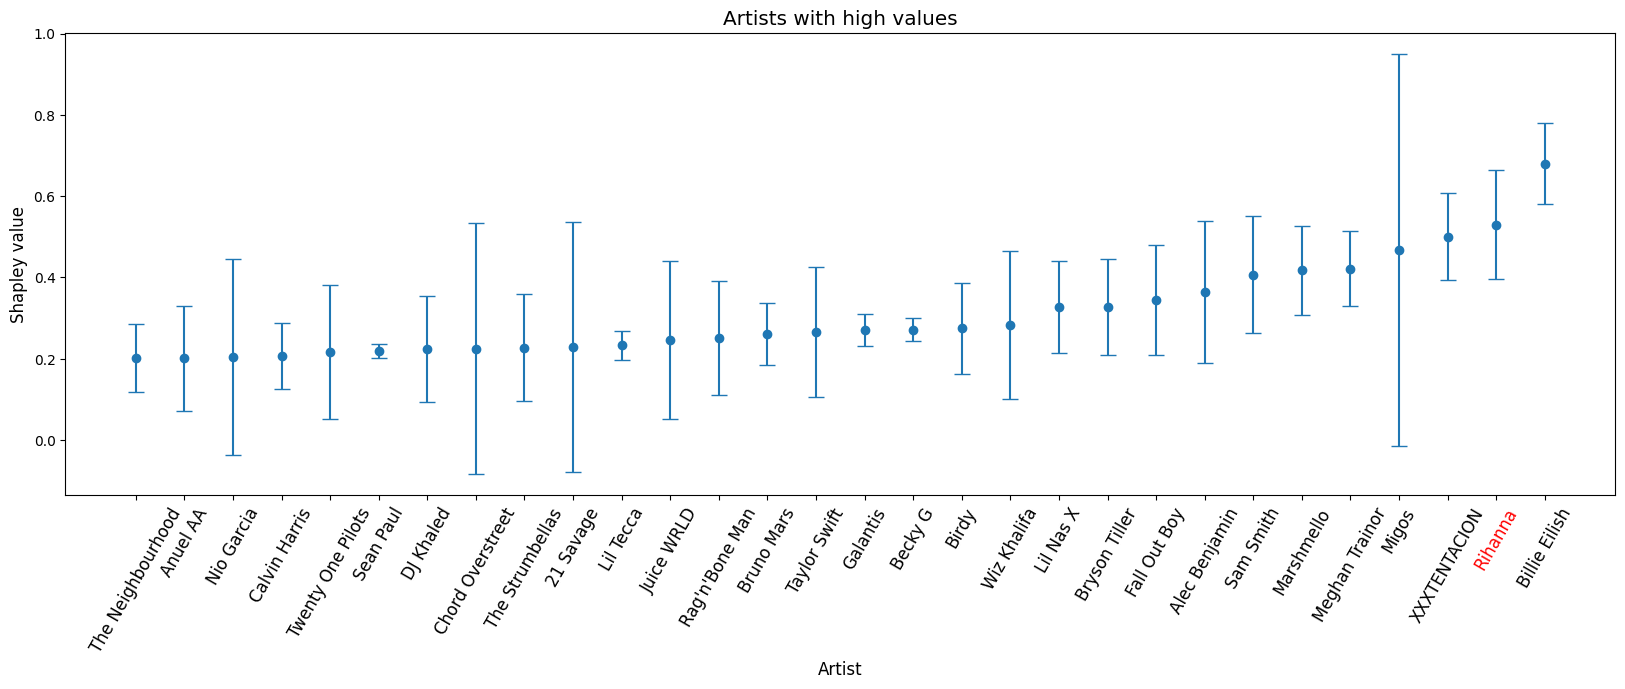

In [15]:
high_dvl = df.iloc[-30:]
fig, ax = plt.subplots()
plot_shapley(
    high_dvl,
    ax=ax,
    title="Artists with high values",
    xlabel="Artist",
    ylabel="Shapley value",
)
ax.get_xticklabels()[high_dvl.index.get_loc("Rihanna")].set_color("red")
plt.show()

Let us take all the songs by Rihanna, set their score to 0 and re-calculate the Shapley values.

<div class="alert alert-warning">

Notice that we use a new name for the `Dataset`, in order to trigger usage of a different cache. Reusing the old one would be a mistake because modifying even just one label changes all the Shapley values, which means that we cannot reuse any utility computations.

</div>

In [16]:
y_train_anomalous = training_data[1].copy(deep=True)
y_train_anomalous[artist == "Rihanna"] = 0
anomalous_dataset = Dataset(
    x_train=training_data[0],
    y_train=y_train_anomalous,
    x_test=val_data[0],
    y_test=val_data[1],
)
grouped_anomalous_dataset = GroupedDataset.from_dataset(anomalous_dataset, artist)
anomalous_utility = Utility(
    model=GradientBoostingRegressor(n_estimators=3),
    data=grouped_anomalous_dataset,
    scorer=Scorer("neg_mean_absolute_error", default=0.0),
    enable_cache=True,
)
values = compute_shapley_values(
    anomalous_utility,
    mode=ShapleyMode.TruncatedMontecarlo,
    done=RelativeStandardError(threshold=0.3, fraction=0.9) | MaxUpdates(200),
    n_jobs=-1,
    worker_update_period=0.5,
    coordinator_update_period=1,
)
values.sort(key="value")
df = values.to_dataframe(column="data_value", use_names=True)

Let us now consider the low-value artists (at least for predictive purposes, no claims are made about their artistic value!) and plot the results

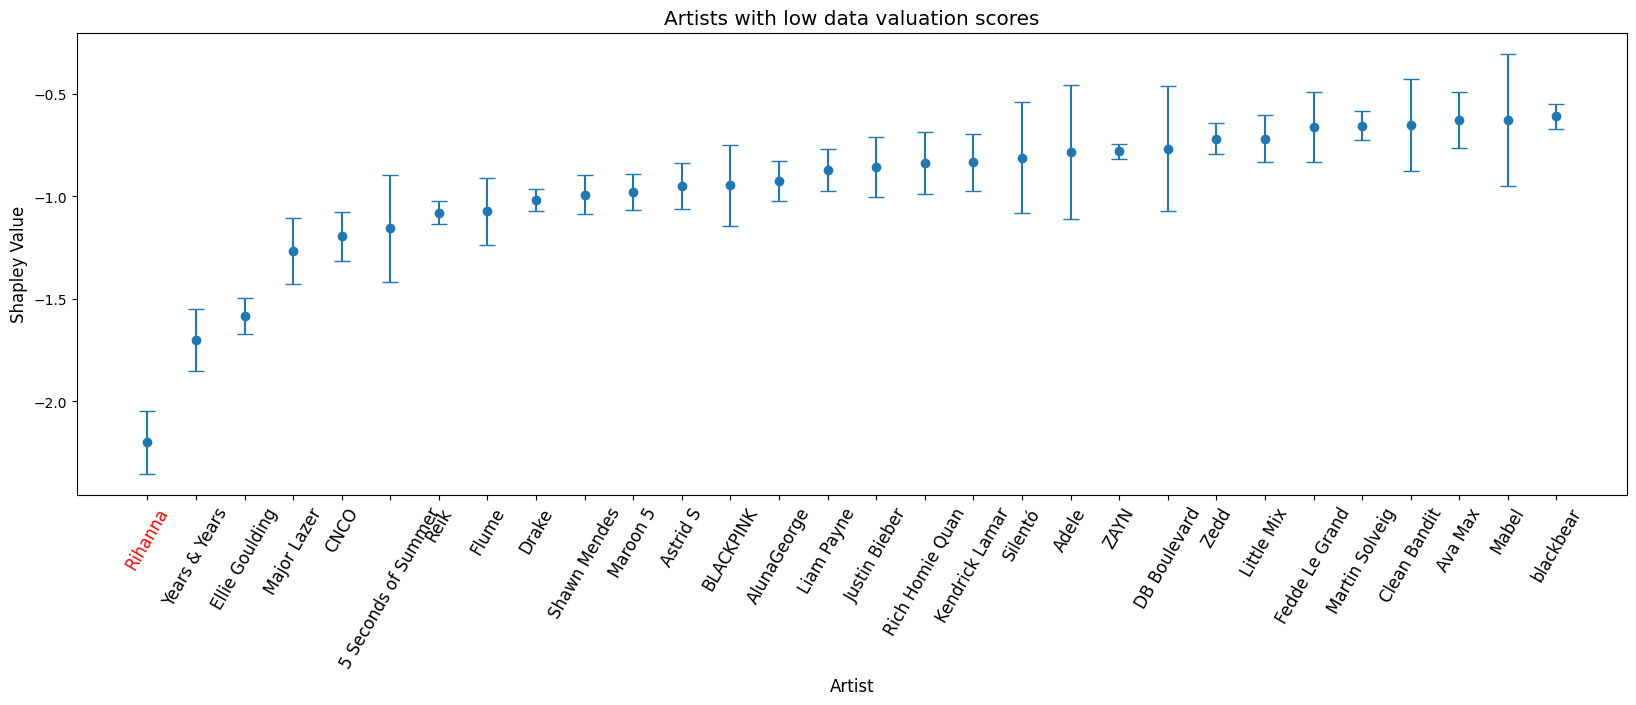

In [17]:
low_dvl = df.iloc[:30]
fig, ax = plt.subplots()
ax = plot_shapley(
    low_dvl,
    ax=ax,
    title="Artists with low data valuation scores",
    xlabel="Artist",
    ylabel="Shapley Value",
)
ax.get_xticklabels()[low_dvl.index.get_loc("Rihanna")].set_color("red")
plt.show()

And Rihanna (our anomalous data group) has moved from top contributor to having negative impact on the performance of the model, as expected!

What is going on? A popularity of 0 for Rihanna's songs is inconsistent with listening patterns for other artists. In artificially setting this, we degrade the predictive power of the model.

By dropping low-value groups or samples, one can often increase model performance, but by *inspecting* them, it is possible to identify bogus data sources or acquisition methods.
